#Paquetes necesarios

In [17]:
import cv2
import pytesseract
import glob
import os
import matplotlib.pyplot as plt

Primeras pruebas 

['eng', 'equ', 'osd', 'spa', 'spa_old']
Namespace(weights=['C:\\Users\\rauln\\anaconda3\\envs\\yolov7\\yolov7.pt'], source='images\\IMG20221105141550.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='0', view_img=True, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 person, 10 cars, 1 truck, Done. (11.5ms) Inference, (3.0ms) NMS
 The image with the result is saved in: runs\detect\exp12\IMG20221105141550.jpg
Done. (0.145s)


YOLOR  v0.1-115-g072f76c torch 1.13.0 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191.5MB)

Model Summary: 306 layers, 36905341 parameters, 6652669 gradients
c:\Users\rauln\anaconda3\envs\yolov7\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


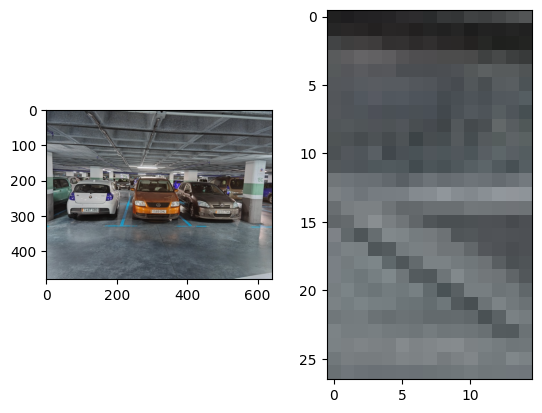

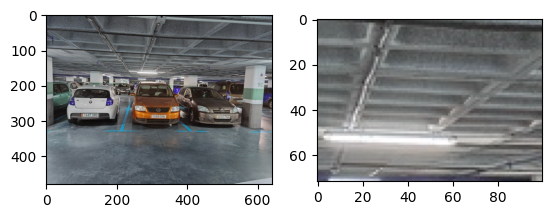

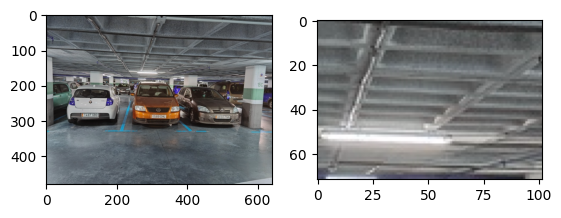

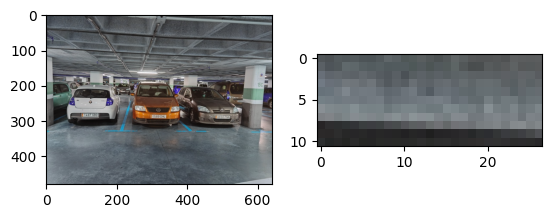

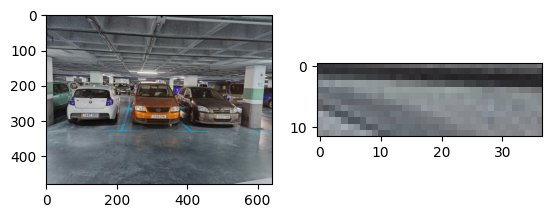

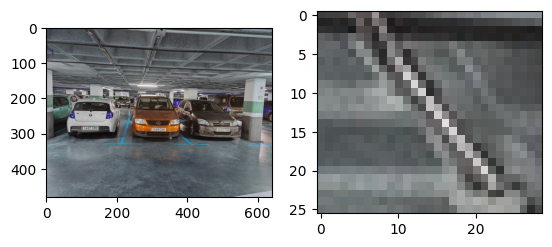

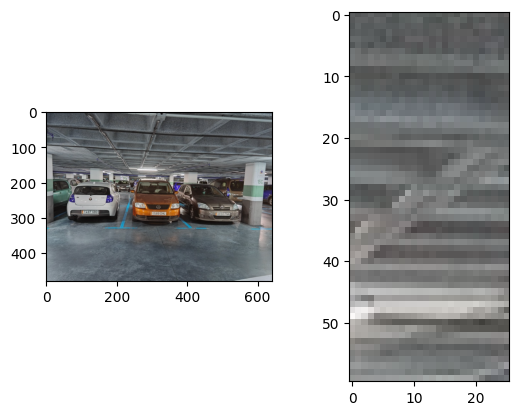

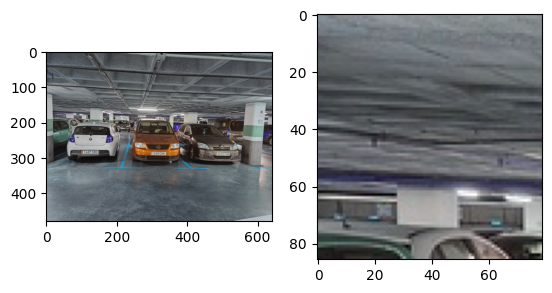

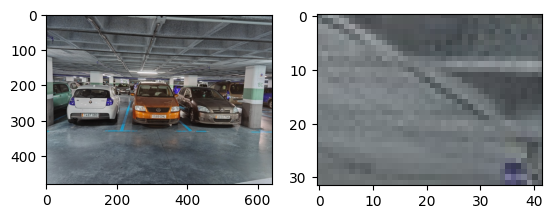

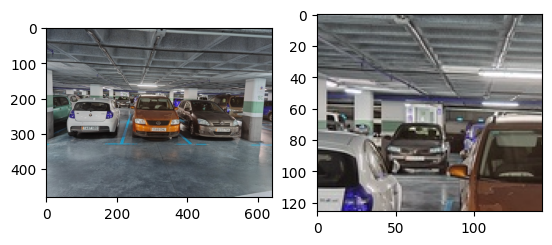

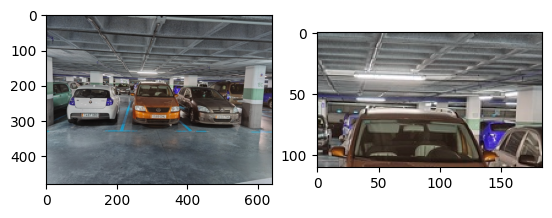

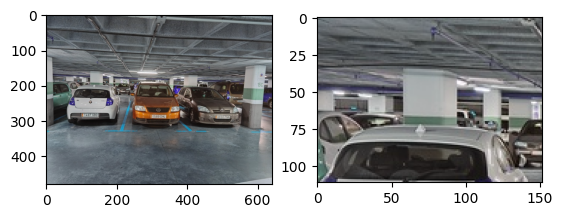

In [19]:
# Si la ruta de Tesseract no está en el PATH, ruta al ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

# Lenguajes disponibles
print(pytesseract.get_languages(config=''))

#Cargo imagen y ocnvierto a RGB
img = cv2.imread('images\IMG20221105141550.jpg') 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Aplica reconocedor a imagen cargada
#print(pytesseract.image_to_string(img_rgb))

!python C:\Users\rauln\anaconda3\envs\yolov7\detect.py --weights C:\Users\rauln\anaconda3\envs\yolov7\yolov7.pt --conf 0.25 --source images\IMG20221105141550.jpg --view-img --save-txt --device 0

list_of_files = glob.glob('runs\detect\*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
file_name = latest_file + "\labels\*"
file = glob.glob(file_name)

# removing the new line characters
with open(file[0]) as f:
    lines = [line.rstrip() for line in f]
  
for line in lines:
    coordinates = line.split()
    H, W, _ = img.shape
    object = [int(float(coordinates[1])*W/2), int(float(coordinates[2])*H/2), int(float(coordinates[3])*W), int(float(coordinates[4])*H)]   
    x,y,w,h = object
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(img[y:y+h, x:x+w])
    plt.show()